In [1]:
import sys
sys.path.append('../..')
from src.pomdp import *

from matplotlib import pyplot as plt
from tqdm.notebook import tqdm, trange
import pandas as pd
import numpy as np
import json
import cv2

from viz_functions import *

In [2]:
model = Model.load_from_file('./Models/Alt_Wrap_GroundAir.pck')
vf = ValueFunction.load_from_file('./Test_Results/Test_GroundAir_FSVI_300it_100exp_099g_e6eps_20run_20231121_165329/ValueFunctions/run-3-VF.gzip', model)

In [3]:
# MDP solution
vi_solver = VI_Solver()
mdp_solution, hist = vi_solver.solve(model, use_gpu=False, print_progress=True)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [4]:
solver = FSVI_Solver(mdp_policy=mdp_solution)

In [5]:
# Run 300 iterations of expand with 100 beliefs generation (total: 30000)
all_bs = []
for _ in range(300):
    bs = solver.expand(model, BeliefSet(model, [Belief(model)]), 100, **solver.expand_function_params)
    all_bs.append(bs)

In [6]:
# Belief list
all_beliefs = []
for bs in all_bs:
    all_beliefs.extend(bs._belief_list)

In [7]:
# Unique belief list
uniqueness_dict = {belief.values.tobytes(): belief for belief in all_beliefs}
belief_list = list(uniqueness_dict.values())

In [9]:
# Make belief_set object
belief_set = BeliefSet(model, belief_list)

In [21]:
def delete_n(vf_old, n):
    # Compute matrix multiplications between avs and beliefs
    alpha_value_per_belief = np.matmul(vf_old.alpha_vector_array, belief_set.belief_array.T)

    # Select the useful alpha vectors
    best_alpha_vector_per_belief = np.argmax(alpha_value_per_belief, axis=0)
    useful_alpha_vectors = np.unique(best_alpha_vector_per_belief)

    # Select a random selection of vectors to delete
    random_vectors_to_delete = np.random.choice(np.delete(np.arange(len(vf_old)), useful_alpha_vectors), size=n, replace=False)

    value_function = ValueFunction(model=model,
                                    alpha_vectors=np.delete(vf_old.alpha_vector_array, random_vectors_to_delete, axis=0),
                                    action_list=np.delete(vf_old.actions, random_vectors_to_delete))
    
    return value_function

In [12]:
from test_setups import grid_test

In [14]:
vf_gpu = vf.to_gpu()

[02/27/2024, 12:40:09] Sending Model to GPU...
[02/27/2024, 12:40:09]     > Done in 0.390s


In [15]:
res_df = grid_test(vf_gpu)

All 780 simulations done in 105.568s:
	- Simulations reached goal: 780/780 (0 failures)
	- Average step count: 239.43333333333334
	- Average total rewards: 1.0
	- Average discounted rewards (ADR): 0.19754103943352405


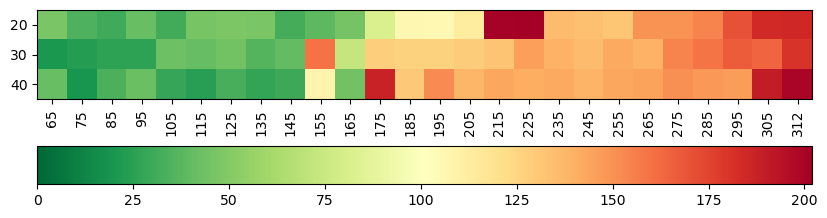

In [19]:
fig, ax = plt.subplots(1, figsize=(10,4))
im = plot_grid_extra_steps(res_df, ax=ax)
plt.colorbar(im, ax=ax, location='bottom', orientation='horizontal')

In [22]:
res_dfs = []
for i in range(16):
    print(f'\nStarting {i+1}')
    value_function = delete_n(vf, (i+1)*400)
    res_df = grid_test(value_function.to_gpu())
    res_dfs.append(res_df)


Starting 1
All 780 simulations done in 124.027s:
	- Simulations reached goal: 765/780 (15 failures)
	- Average step count: 249.31794871794872
	- Average total rewards: 0.9807692307692307
	- Average discounted rewards (ADR): 0.1954949060977856

Starting 2
All 780 simulations done in 122.666s:
	- Simulations reached goal: 338/780 (442 failures)
	- Average step count: 615.4666666666667
	- Average total rewards: 0.43333333333333335
	- Average discounted rewards (ADR): 0.17131623434629492

Starting 3
All 780 simulations done in 120.915s:
	- Simulations reached goal: 358/780 (422 failures)
	- Average step count: 594.35
	- Average total rewards: 0.45897435897435895
	- Average discounted rewards (ADR): 0.17372718032140025

Starting 4
All 780 simulations done in 119.851s:
	- Simulations reached goal: 346/780 (434 failures)
	- Average step count: 608.05
	- Average total rewards: 0.44358974358974357
	- Average discounted rewards (ADR): 0.169060981917456

Starting 5
All 780 simulations done in 11

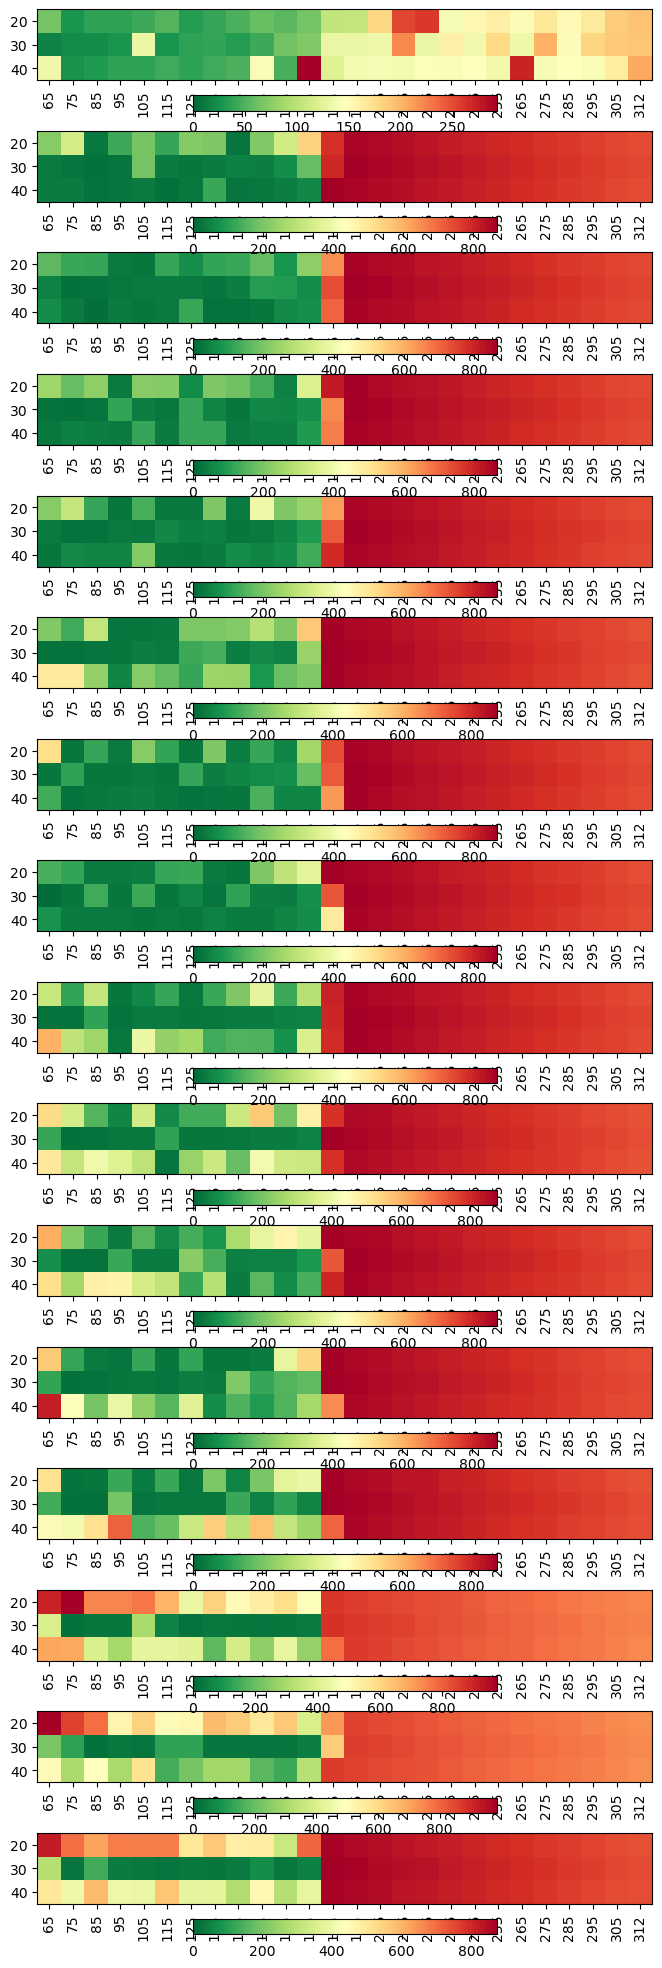

In [26]:
fig, axes = plt.subplots(16, figsize=(10,25))
for i, (ax, df) in enumerate(zip(axes, res_dfs)):
    # df.to_csv(f'./Test_AV_removal/{(i+1)*400}_removed.csv')fig, ax = plt.subplots(1, figsize=(10,4))
    im = plot_grid_extra_steps(df, ax=ax)
    plt.colorbar(im, ax=ax, location='bottom', orientation='horizontal')